In [1]:
#@title import modules
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy.polynomial.polynomial import polyfit
from PIL import Image, ImageShow
from IPython.display import clear_output
import numpy as np
import pandas as pd
import torch
import os
from tqdm import tqdm, trange
from collections import Counter
import ast

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.ndimage import gaussian_filter
from scipy.stats import ttest_1samp

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nilearn
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import datasets as ndata

In [ ]:
#@title data path
cwd = os.getcwd()
roi_mask_path = cwd + '/fMRI_data/ROI_masks_/'
glm_data_path = cwd + '/fMRI_data/GLM_data/'
glm_rearranged = cwd + '/fMRI_data/GLM_data/GLM_rearranged/'
activation_data_path = cwd + '/fMRI_data/activation_data/'
voxel_correlation_path = cwd + '/fMRI_data/activation_data/voxel_correlation/'
presentation_order_path = cwd + '/Stimuli_Presentation_Lists/'
dir_BOLD5000 = '/content/drive/MyDrive/metabolic_aesthetics/images/BOLD5000_Stimuli/all_presented_images'
final_data_path = cwd + '/fMRI_data/final_data/'

proj_dir = cwd 
dir_model = cwd + "/Models/"
dir_sta = cwd + "/statistics/"
dir_ratings = cwd + "/Ratings_BOLD5000.csv"
dir_BOLD5000 = cwd + "/images/BOLD5000_Stimuli/all_presented_images"
model_data_dir = cwd + "/model_data/"

/content


In [ ]:
#@title Util functions

def scale(data, scale=False):
    
    if len(data) ==0:
        return []

    mean = sum(data) / len(data)
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = variance ** 0.5

    # Avoid division by zero in case of zero variance
    if std_dev == 0:
        return [0] * len(data)
    if scale:
        return [(x - mean) / std_dev for x in data]
    else:
        return [(x - mean) for x in data]


def find_repeated_indices(lst):
  seen = []
  repeated_indices = []

  for index, item in enumerate(lst):
    if item not in seen:
      seen.append(item)
    else:
      repeated_indices.append(index)

  return repeated_indices


def remove_nan_values(A, B):
    # Remove NaN values using boolean indexing
    valid_indices = ~np.isnan(A) & ~np.isnan(B)
    A_valid = A[valid_indices]
    B_valid = B[valid_indices]
    return A_valid, B_valid

def cal_r_squared(model, X, y):
  yhat = model.predict(X)
  SS_Residual = sum((y-yhat)**2)
  SS_Total = sum((y-np.mean(y))**2)
  r_squared = 1 - (float(SS_Residual))/SS_Total
  adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-len(X)-1)
  return r_squared, adjusted_r_squared

def coef_compute(metabolic_costs, ratings_to_predict):
  regression = LinearRegression()

  results = []
  for i in range(len(metabolic_costs[0])):
    l = [metabolic_costs[j][:i+1] for j in range(len(metabolic_costs))]
    regression.fit(l, ratings_to_predict)
    results.append(regression.coef_[-1])
  results = np.array(results)

  return results

def compute_R_squared(train_x, validate_x, train_y, validate_y):
  regression = LinearRegression()

  results = []
  for i in range(len(train_x[0])):
    l = [train_x[j][:i+1] for j in range(len(train_x))]
    regression.fit(l, train_y)
    l_val = [validate_x[j][:i+1] for j in range(len(validate_x))]
    r_2, _ = cal_r_squared(regression, l_val, validate_y)
    results.append(r_2)

  individual_account = [results[i+1]-results[i] for i in range(len(results)-1)]
  individual_account.insert(0, results[0])

  return results, individual_account


def rearrange_neuroimages(array, new_order):
    # Check if the input array is 4D
    if len(array.shape) != 4:
        raise ValueError("Input array must be 4-dimensional.")

    # Check if the new order is valid
    if len(new_order) != array.shape[-1] or sorted(new_order) != list(range(array.shape[-1])):
        raise ValueError("Invalid new order.")

    # Rearrange the neuroimages based on the new order
    rearranged_array = array[..., new_order]

    return rearranged_array


def average_neuroimages(array, indices_to_average):
    # Check if the input array is 4D
    if len(array.shape) != 4:
        raise ValueError("Input array must be 4-dimensional.")

    # Check if the indices to average are valid
    num_neuroimages = array.shape[-1]
    if any(index >= num_neuroimages or index < 0 for index in indices_to_average):
        raise ValueError("Invalid indices to average.")

    # Select the specified neuroimages and compute the average
    averaged_array = np.mean(array[..., indices_to_average], axis=-1)

    return averaged_array


def delete_neuroimages(array, indices_to_delete):
    # Check if the input array is 4D
    if len(array.shape) != 4:
        raise ValueError("Input array must be 4-dimensional.")

    # Check if the indices to delete are valid
    num_neuroimages = array.shape[-1]
    if any(index >= num_neuroimages or index < 0 for index in indices_to_delete):
        raise ValueError("Invalid indices to delete.")

    # Create a boolean mask to select the neuroimages to keep
    mask = np.ones(num_neuroimages, dtype=bool)
    mask[indices_to_delete] = False

    # Delete the specified neuroimages
    filtered_array = array[..., mask]

    return filtered_array

def calculate_cor_CI(
    count,
    r,
    alpha
    ):
  """
  Calculate the confidence interval for the correlation coefficient.
  """
  stderr = 1.0 / np.sqrt(count - 3)
  z = abs(stats.norm.ppf(1-alpha/2))
  delta = z * stderr
  lower = np.tanh(np.arctanh(r) - delta)
  upper = np.tanh(np.arctanh(r) + delta)
  return lower, upper

def compute_correlation(
    region,
    metric,
    ratings_name_list,
    dataset=None
    ):
  """
  Compute correlations by metric type and dataset.
  """
  df = pd.read_csv(activation_data_path+f'{metric}_rep_avg_subject_avg.csv')

  name_list = list(df['image'])
  stimuli_names = name_list
  if dataset == 'Scenes':
    stimuli_names = [name for name in name_list \
                     if ((not name.startswith('COCO')) & (not name.startswith('n0')) & (not name.startswith('n1')))]
  elif dataset=='COCO':
    stimuli_names = [name for name in name_list if name.startswith('COCO')]
  elif dataset == 'ImageNet':
    stimuli_names = [name for name in name_list \
                     if ((name.startswith('n1')) or (name.startswith('n0')))]

  metabolic_costs_l = [df[df.image==name][region].iloc[0] \
                     for name in stimuli_names if name in ratings_name_list]
  pleasure_ratings_l = [df_ratings[df_ratings.name==name]['pleasure_rating'].iloc[0] \
                      for name in stimuli_names if name in ratings_name_list]
  # Spearman rank correlation test
  correlation = spearmanr(metabolic_costs_l, pleasure_ratings_l)[0]
  p_value = spearmanr(metabolic_costs_l, pleasure_ratings_l)[1]
  # calculate CI
  lower, upper = calculate_cor_CI(len(metabolic_costs_l), correlation, 0.05)

  return correlation, p_value, metabolic_costs_l, pleasure_ratings_l, lower, upper


def get_subset_img_names(subset):
    df = pd.read_csv(activation_data_path+f'{metric}_rep_avg_subject_avg.csv')

    name_list = list(df['image'])
    stimuli_names = name_list
    if subset == 'Scenes':
      stimuli_names = [name for name in name_list \
                      if ((not name.startswith('COCO')) & (not name.startswith('n0')) & (not name.startswith('n1')))]
    elif subset=='COCO':
      stimuli_names = [name for name in name_list if name.startswith('COCO')]
    elif subset == 'ImageNet':
      stimuli_names = [name for name in name_list \
                      if ((name.startswith('n1')) or (name.startswith('n0')))]
    return stimuli_names


def significance_markers(
    p_vals
    ):
  p_vals = list(p_vals)
  markers = []
  for p in p_vals:
    if p >= 0.05:
      markers.append('')
    elif 0.01 <= p < 0.05:
      markers.append('*')
    elif 0.001 <= p < 0.01:
      markers.append('**')
    elif p < 0.001:
      markers.append('***')
  return markers


def align_translation(source_img, target_img):
  # Extract the affine matrix of the mask image
  affine_source_img = source_img.affine.copy()

  # Extract the translation components from the GLM_data image's affine matrix
  translation_components = target_img.affine[:3, 3]

  # Update the translation components in the mask image's affine matrix
  affine_source_img[:3, 3] = translation_components

  # Create a new image with the modified affine matrix
  source_img_translated = nib.Nifti1Image(source_img.get_fdata(), affine_source_img)

  return source_img_translated


def transform_affine(source_img, target_img):
    affine_source = target_img.affine.copy()
    affine_source[:, :] = target_img.affine[:, :]
    transformed_img = nib.Nifti1Image(source_img.get_fdata(), affine_source)
    return transformed_img


def create_nif(array_data, target_img=None, use_affine=False, target_affine=None):
  # Extract the affine of the target_img
  if use_affine == False:
    target_affine = target_img.affine.copy()

  # Create a new image with the array data and the target affine
  new_img = nib.Nifti1Image(array_data, target_affine)

  return new_img

# Collect data

In [ ]:
#@title Func: Calculate activation metric
def compute_activation_metric(
    roi_data,
    mode
    ):
  """Compute activation intensity of ROIS
  with different metrics.
  """
  if mode == 'count_positive':
    result = (roi_data > 0).sum()
  elif mode == 'l1_norm':
    where_are_NaNs = np.isnan(roi_data)
    roi_data[where_are_NaNs] = 0
    result = np.sum(np.abs(roi_data))
  elif mode == 'mean_count_positive':
    mean = np.nanmean(roi_data)
    result = (roi_data-mean>0).sum()
  elif mode == 'proportion':
    n_total_units = (roi_data != 0).sum()
    n_activated_units = (roi_data > 0).sum()
    result = n_activated_units/n_total_units
  elif mode == 'sum_positive':
    where_are_NaNs = np.isnan(roi_data)
    roi_data[where_are_NaNs] = 0
    roi_data[roi_data < 0] = 0
    result = np.sum(roi_data)
  elif mode == 'sum_all':
    where_are_NaNs = np.isnan(roi_data)
    roi_data[where_are_NaNs] = 0
    result = np.sum(roi_data)
  return result

In [ ]:
#@title Func: load_img_names
def load_img_names(
    sess,
    subject
    ):
  whole_presentation_list = []
  if sess <= 9:
    num_runs = len(os.listdir(presentation_order_path+f'CSI{subject}/CSI{subject}_sess0{sess}/'))/2
  else:
    num_runs = len(os.listdir(presentation_order_path+f'CSI{subject}/CSI{subject}_sess{sess}/'))/2

  for run in range(1,int(num_runs)+1):
    if sess <= 9:
      if run <= 9:
        dir = presentation_order_path+f"CSI{subject}/CSI{subject}_sess0{sess}/CSI{subject}_sess0{sess}_run0{run}.txt"
      else:
        dir = presentation_order_path+f"CSI{subject}/CSI{subject}_sess0{sess}/CSI{subject}_sess0{sess}_run{run}.txt"
    else:
      if run <= 9:
        dir = presentation_order_path+f"CSI{subject}/CSI{subject}_sess{sess}/CSI{subject}_sess{sess}_run0{run}.txt"
      else:
        dir = presentation_order_path+f"CSI{subject}/CSI{subject}_sess{sess}/CSI{subject}_sess{sess}_run{run}.txt"
    with open(dir, "r") as presentation_order_list:
      lines = presentation_order_list.readlines()
      whole_presentation_list.extend(lines)
  whole_presentation_list = [i.replace("\n", "") for i in whole_presentation_list]

  return whole_presentation_list

In [ ]:
#@title Collect activation patterns of each ROI
# df = pd.DataFrame(columns=['image', 'subject', 'V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA', 'LHRSC', 'RHRSC'])
num_subjects = 4
for p in range(num_subjects):
  df = pd.DataFrame(columns=['image', 'subject', 'V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA'])

  subject = p+1 # 1, 2, 3, 4
  mode = 'sum_all' # 'count_positive', 'l1_norm', 'proportion', 'sum_positive'
  sessions = [i+1 for i in range(15)]
  if subject == 4:
    sessions = [i+1 for i in range(9)]
  image_list = []
  mask_list = ['V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA']

  for ses in sessions:
    if ses < 10:
      GLM_data = nib.load(glm_data_path+f'CSI{subject}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-0{ses}.nii.gz')
    else:
      GLM_data = nib.load(glm_data_path+f'CSI{subject}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-{ses}.nii.gz')
    GLM_data = GLM_data.get_fdata()

    images = load_img_names(ses, subject)
    for count, image_name in enumerate(images):
      # iterate through the mask list to collect activations data of all roi
      activation_list = []
      for mask_name in mask_list:
        if 'RSC' in mask_name:
          mask = nib.load(roi_mask_path+f'sub-CSI{subject}/my{mask_name}.nii.gz')
        else:
          mask = nib.load(roi_mask_path+f'sub-CSI{subject}/my{mask_name}.nii')
        mask_data = mask.get_fdata()
        roi_data = GLM_data[:, :, :, count] * mask_data
        metric = compute_activation_metric(roi_data, mode)
        activation_list.append(metric)
      image_info = [image_name, subject] + activation_list
      print(p, ses, round(count/len(images),2))
      clear_output(wait=True)
      df.loc[len(df)] = image_info

  df.to_csv(activation_data_path+f'subject{subject}_{mode}.csv', index=False, sep=',')

In [ ]:
#@title Integrate session data
num_subjects = 4
save_path = glm_rearranged
for p in range(2, num_subjects):
  # for half_index in range(1, 3):
  image_name_df = pd.DataFrame(columns=['name'])
  subject = p+1 # 1, 2, 3, 4
  mode = 'sum_all'
  sessions = [i+1 for i in range(15)]
  if subject == 4:
    sessions = [i+1 for i in range(9)]
  image_list = []
  data_to_save_list = []

  # the file names have been reformatted to the same style. Remove if-else here.
  for ses in tqdm(sessions):
    if ses < 10:
      GLM_image = nib.load(glm_data_path+f'CSI{subject}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-0{ses}.nii.gz')
    else:
      GLM_image = nib.load(glm_data_path+f'CSI{subject}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-{ses}.nii.gz')
    GLM_data = GLM_image.get_fdata()
    # half_height = GLM_data.shape[2]/2
    # if half_index == 1:
    #   GLM_data = GLM_data[:, :, :int(half_height), :]
    # else:
    #   GLM_data = GLM_data[:, :, int(half_height):, :]

    images = load_img_names(ses, subject)
    image_list.extend(images)

    if ses == 1:
      data_to_save = GLM_data
    else:
      data_to_save = np.concatenate((data_to_save, GLM_data), axis=-1)
      # print('before deletion:', data_to_save.shape)
  image_list_unique = [name.replace('rep_', '') for name in image_list]
  image_list_unique = list(set(image_list_unique))

  # rep_image_indices = [index for index, value in enumerate(image_list) if (value.startswith('rep_'))]
  # if subject == 4:
  #   image_list_ = [name.replace('rep_', '') for name in image_list]
  #   rep_image_indices= find_repeated_indices(image_list_)

  shape_ = data_to_save.shape
  res = np.zeros((shape_[0], shape_[1], shape_[2], len(image_list_unique)))
  for loc, image in tqdm(enumerate(image_list_unique)):
    indices = [index for index, val in enumerate(image_list) if (val == image) or (val == 'rep_'+image)]
    averaged_array = average_neuroimages(data_to_save, indices)
    res[:, :, :, loc] = averaged_array
    # if loc == 0:
    #   res = averaged_array
    # else:
    #   res = np.concatenate((res, averaged_array), axis=-1)

  # data_to_save = delete_neuroimages(data_to_save, rep_image_indices)
  print('after deletion', res.shape)
  neuroimage_rearranged = create_nif(res, GLM_image)
  image_name_df['name'] = image_list_unique

  # image_name_df.to_csv(save_path+f'GLM_subject{subject}_image_order_.csv')
  # nib.save(neuroimage_rearranged, save_path+f'GLM_subject{subject}_half{half_index}_.nii.gz')
  image_name_df.to_csv(save_path+f'GLM_subject{subject}_image_order_.csv')
  nib.save(neuroimage_rearranged, save_path+f'GLM_subject{subject}_.nii.gz')

  del data_to_save, GLM_image, GLM_data, neuroimage_rearranged, res
  clear_variables()
  print(subject)

100%|██████████| 15/15 [04:20<00:00, 17.34s/it]
4916it [01:19, 61.80it/s]


after deletion (72, 88, 67, 4916)
3


100%|██████████| 9/9 [02:59<00:00, 19.90s/it]
2952it [00:44, 66.04it/s]


after deletion (70, 89, 70, 2952)
4


In [ ]:
#@title Average the metrics for repeated images
num_subjects = 4
rois = ['V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA']
for subject in range(num_subjects):
  subject = subject +1
  mode = 'sum_all'
  df = pd.read_csv(activation_data_path+f'subject{subject}_{mode}.csv')
  df_new = pd.DataFrame(columns=['image', 'subject', 'V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA'])

  img_name_list = df['image']
  for i in trange(len(df)):
    image_name = img_name_list[i]
    new_data_line = None
    if not image_name.startswith('rep'):
      roi_data = df[(df.image == image_name)|(df.image == 'rep_'+image_name)][rois].mean()
      new_data_line = [image_name, subject] + list(roi_data)
      df_new.loc[len(df_new)] = new_data_line
  df_new.to_csv(activation_data_path+f'subject{subject}_{mode}_rep_average.csv', index=False, sep=',')

In [ ]:
#@title Average the roi metrics across subjects for each image
df_pool = pd.DataFrame(columns=['image', 'subject', 'V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA'])
df_average = pd.DataFrame(columns=['image', 'V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA'])
rois = ['V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA']
num_subjects = 4
mode = 'sum_all'

for subject in range(num_subjects):
  subject = subject + 1
  df = pd.read_csv(activation_data_path+f'subject{subject}_{mode}_rep_average.csv')
  df_pool = pd.concat([df_pool, df])

image_name_list = list(set(df_pool['image']))
for name in tqdm(image_name_list):
  new_data_line = None
  roi_data = df_pool[(df_pool.image == name)][rois].mean()
  new_data_line = [name] + list(roi_data)
  df_average.loc[len(df_average)] = new_data_line

df_average.to_csv(activation_data_path+f'{mode}_rep_avg_subject_avg.csv', index=False, sep=',')

# Analysis

In [ ]:
#@title prepare the dataset for 10-fold cross validation
df_ratings = pd.read_csv(dir_ratings)
pleasure_ratings = np.array(df_ratings['pleasure_rating'])
complexity_ratings = np.array(df_ratings['complexity_rating'])
name_list = list(df_ratings['name'])
df_sparsity_data = pd.DataFrame()
length = len(name_list)

train_set, test_set = [], []
train_ind_set, test_ind_set = [], []
kf = KFold(n_splits=10, shuffle=True, random_state=0)
for train_index, test_index in kf.split(name_list):
  # print("TRAIN:", train_index, "TEST:", test_index)
  # print('train len:', len(train_index))
  # print('test len:', len(test_index))
  train_ind_set.append(list(train_index))
  test_ind_set.append(list(test_index))
  train_set.append([name_list[ind] for ind in train_index])
  test_set.append([name_list[ind] for ind in test_index])

In [37]:
#@title Fit the regression model of activations to predict pleasure ratings (average across ps)
metric = 'sum_all'
df = pd.read_csv(activation_data_path+f'{metric}_rep_avg_subject_avg.csv')
regions = ['V1', 'V2', 'V3', 'V4', 'LOC', 'OPA', 'PPA','FFA', ]
# df = df1
# prepare the data
regression_pleasure = LinearRegression()

fz_ple = []
alphas_ple = []
pred_ple_list = []
gt_ple_list = []
variance_accounted_cuml = []
variance_accounted_individual = []
r_list_ple = []


regressors = [[df[df.image==name][regions[i]].iloc[0] for i in range(len(regions))]
              for name in name_list if name in list(df['image'])]

# 10 fold cross-validation
for j in range(10):
  print(j)
  regression_pleasure = LinearRegression()

  regressors_train = [regressors[m] for m in train_ind_set[j]]
  pleasure_ratings_train = [pleasure_ratings[m] for m in train_ind_set[j]]

  pleasure_ratings_test = [pleasure_ratings[m] for m in test_ind_set[j]]
  regressors_test = [regressors[m] for m in test_ind_set[j]]

  # fit the models

  cumulative_account, individual_account = compute_R_squared(regressors_train,
                                                             regressors_test,
                                                             pleasure_ratings_train,
                                                             pleasure_ratings_test
                                                             )

  variance_accounted_cuml.append(cumulative_account)
  variance_accounted_individual.append(individual_account)

  regression_pleasure.fit(regressors_train, pleasure_ratings_train)

  ple_coef = regression_pleasure.coef_

  alphas_ple.append(ple_coef)

  # make predictions
  pred_ple = regression_pleasure.predict(regressors_test)
  pred_ple_list.extend(pred_ple)
  gt_ple = pleasure_ratings_test
  gt_ple_list.extend(gt_ple)

correlation = spearmanr(pred_ple_list, gt_ple_list)[0]
p_value = spearmanr(pred_ple_list, gt_ple_list)[1]

fz_ple = np.arctanh(r_list_ple)

clear_output(wait=True)

# save the data

# np.savetxt(dir+sparsity_condition_+regressor_condition+type_+"_final_fisher-z_pleasure.csv", fz_ple, delimiter=',', fmt='%s')

variance_accounted_cuml_mean, variance_accounted_individual_mean = [], []
for i in range(len(variance_accounted_cuml[0])):
  variance_accounted_cuml_mean.append(np.mean([variance_accounted_cuml[k][i] for k in range(10)]))
# np.savetxt(dir+sparsity_condition_+regressor_condition+type_+'_variance_accounted_cumulative.csv', variance_accounted_cuml_mean, delimiter=',', fmt='%s')

for i in range(len(variance_accounted_individual[0])):
  variance_accounted_individual_mean.append(np.mean([variance_accounted_individual[k][i] for k in range(10)]))
# np.savetxt(dir+sparsity_condition_+regressor_condition+type_+'_variance_accounted_individual.csv', variance_accounted_individual_mean, delimiter=',', fmt='%s')

print('mean R^2:', variance_accounted_cuml_mean[-1])
print('correlation:', round(correlation, 4), p_value)
print('explained variance by region:', variance_accounted_individual_mean)

mean R^2: 0.03162200982820175
correlation: 0.1854 3.0742505591613805e-39
explained variance by region: [0.00015090853583887842, -0.0002834852258641662, -0.00011377204910429927, 0.005663042327414014, 0.0003228849493252861, 0.009506125947161747, 0.005807787686083676, 0.01056851765734661]


In [ ]:
#@title Compute voxel-wise correlations
def calculate_voxel_correlation(subject, spatial_smoothing, fwhm):
  image_order_df = pd.read_csv(glm_rearranged+f'GLM_subject{subject}_image_order_.csv')
  subject_data = nib.load(glm_rearranged+f'GLM_subject{subject}_.nii.gz')
  affine = subject_data.affine
  subject_data = subject_data.get_fdata()

  shape = subject_data.shape
  print(shape)

  indices = np.indices(shape[:3])
  reshaped_indices = np.reshape(indices, (3, np.prod(shape[:3]))).T

  if spatial_smoothing:
    subject_data = np.nan_to_num(subject_data, nan=0.0)
    subject_data = create_nif(subject_data, use_affine=True, target_affine=affine)
    subject_data = nimg.smooth_img(subject_data, fwhm=fwhm)
    subject_data = subject_data.get_fdata()

  subject_data = np.reshape(subject_data, (np.prod(shape[:3]), shape[-1]))

  pleasure = []
  image_order = image_order_df['name']
  df_ratings = pd.read_csv(dir_ratings)
  ratings_image_list = list(df_ratings['name'])

  for name in image_order:
    if name in ratings_image_list:
      pleasure.append(df_ratings[df_ratings.name==name]['pleasure_rating'].iloc[0])
    else:
      pleasure.append(np.nan)
  pleasure = np.array(pleasure)

  # Compute Spearman's rank correlation
  results = [spearmanr(*(remove_nan_values(subject_data[i], pleasure))) for i in range(subject_data.shape[0])]
  corrs = [val[0] for val in results]
  pvals = [val[1] for val in results]

  return corrs, pvals, reshaped_indices

In [ ]:
#@title Save the correlation map

def save_correlation_result(
    subject,
    corrs,
    pvals,
    indices,
    spatial_smoothing,
    fwhm
    ):
  example_mask = nib.load(roi_mask_path + f'sub-CSI{subject}/myV1.nii')
  example_mask_data = example_mask.get_fdata()
  shape = example_mask.shape

  # corr_template = np.zeros(shape)
  p_template = np.zeros(shape)
  corr_template = np.zeros(shape)

  ## Assign values to the array based on indices
  corr_template[indices[:, 0], indices[:, 1], indices[:, 2]] = corrs
  p_template[indices[:, 0], indices[:, 1], indices[:, 2]] = pvals

  corr_img = create_nif(corr_template, example_mask)
  p_img = create_nif(p_template, example_mask)


  if spatial_smoothing:
    tag = f'_spatial_smoothing_{fwhm}mm'
  else:
    tag = f'_spatial_smoothing_0mm'

  nib.save(corr_img, voxel_correlation_path+f'correlation_cube_subject{subject}{tag}_.nii.gz')
  nib.save(p_img, voxel_correlation_path+f'p_cube_subject{subject}{tag}_.nii.gz')

In [ ]:
# generate the correlation map for each participant, for ploting Figure 3B, Figure S2
num_subjects = 4
fwhm = 4
spatial_smoothing = True
for subject in trange(num_subjects):
  subject += 1
  corrs, pvals, indices = calculate_voxel_correlation(subject, fwhm=fwhm, spatial_smoothing=spatial_smoothing)
  save_correlation_result(
    subject,
    corrs,
    pvals,
    indices,
    spatial_smoothing,
    fwhm
  )

  0%|          | 0/4 [00:00<?, ?it/s]

(71, 89, 72, 4916)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
 25%|██▌       | 1/4 [11:32<34:37, 692.48s/it]

(72, 92, 70, 4916)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
 50%|█████     | 2/4 [24:06<24:17, 728.68s/it]

(72, 88, 67, 4916)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
 75%|███████▌  | 3/4 [35:23<11:45, 705.09s/it]

(70, 89, 70, 2952)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 4/4 [42:52<00:00, 643.21s/it]


# Figures


In [ ]:
#@title Clean data (for separate datasets, subjectwise)
n_subjects = 4
metric_types = ['l1_norm', 'sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA']

datasets = ['Scenes', 'COCO', 'ImageNet']
print(datasets)

df = pd.DataFrame(columns=['subject', 'metric', 'dataset'] + rois)
df_pval = pd.DataFrame(columns=['subject', 'metric', 'dataset'] + rois)

for count, metric in enumerate(metric_types):
  for set_ in datasets:
    for subject in range(n_subjects):
      data_to_plot = []
      data_to_plot_p = []
      for roi_count, roi in enumerate(rois):
        m_list = []
        p_list = []
        _, _, _, metabolic, pleasure = compute_correlation(subject+1, roi, metric, name_list, set_)
        m_list.extend(metabolic)
        p_list.extend(pleasure)

        r, p = spearmanr(m_list, p_list)
        data_to_plot.append(r)
        data_to_plot_p.append(p)

      df.loc[len(df)] = [subject+1, metric, set_] + data_to_plot
      df_pval.loc[len(df_pval)] = [subject+1, metric, set_] + data_to_plot_p
      print(count, set_)

df.to_csv(final_data_path+'roi_individual_correlations_by_dataset_subjectwise.csv', index=False, sep=',')
df_pval.to_csv(final_data_path+'roi_individual_correlation_p_val_by_dataset_subjectwise.csv', index=False, sep=',')

In [ ]:
#@title Clean data (all images, subjectwise)
n_subjects = 4
metric_types = ['sum_all', 'l1_norm']
rois = ['V1', 'V2', 'V3', 'V4', 'PPA', 'FFA', 'LOC', 'OPA']

df = pd.DataFrame(columns=['subject', 'metric'] + rois)
df_pval = pd.DataFrame(columns=['subject', 'metric'] + rois)

for count, metric in enumerate(metric_types):
  for subject in range(n_subjects):
    data_to_plot = []
    data_to_plot_p = []
    for roi_count, roi in enumerate(rois):
      m_list = []
      p_list = []

      _, _, _, metabolic, pleasure = compute_correlation(subject+1, roi, metric, name_list, dataset=None)
      m_list.extend(metabolic)
      p_list.extend(pleasure)

      r, p = spearmanr(m_list, p_list)
      data_to_plot.append(r)
      data_to_plot_p.append(p)

    df.loc[len(df)] = [subject, metric] + data_to_plot
    df_pval.loc[len(df_pval)] = [subject, metric] + data_to_plot_p
    print(count)

df.to_csv(final_data_path+'roi_individual_correlations_by_metric_subjectwise.csv', index=False, sep=',')
df_pval.to_csv(final_data_path+'roi_individual_correlation_p_val_by_metric_subjectwise.csv', index=False, sep=',')

In [ ]:
#@title Clean data (for separate datasets, average)
n_subjects = 4
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
datasets = ['Scenes', 'COCO', 'ImageNet']

df = pd.DataFrame(columns=['metric', 'dataset'] + rois)
df_pval = pd.DataFrame(columns=['metric', 'dataset'] + rois)

for count, metric in enumerate(metric_types):
  for set_ in datasets:
    data_to_plot = []
    data_to_plot_p = []
    for roi_count, roi in enumerate(rois):
      m_list = []
      p_list = []

      r, p, _, _ = compute_correlation(roi, metric, name_list, set_)

      data_to_plot.append(r)
      data_to_plot_p.append(p)

    df.loc[len(df)] = [metric, set_] + data_to_plot
    df_pval.loc[len(df)] = [metric, set_] + data_to_plot_p
    print(count, set_)
df.to_csv(final_data_path+'roi_individual_correlations_by_dataset_item_level_avg.csv', index=False, sep=',')
df_pval.to_csv(final_data_path+'roi_individual_correlation_p_val_by_dataset_item_level_avg.csv', index=False, sep=',')

In [ ]:
#@title Clean data (all images, average)
n_subjects = 4
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']

df = pd.DataFrame(columns=['metric'] + rois)
df_pval = pd.DataFrame(columns=['metric'] + rois)
df_lr = pd.DataFrame(columns=['metric'] + rois)
df_hr = pd.DataFrame(columns=['metric'] + rois)

for count, metric in enumerate(metric_types):
  data_to_plot = []
  data_to_plot_p = []
  lower_rs, higher_rs = [], []
  for roi_count, roi in enumerate(rois):
    # print(name_list)
    print(roi_count)
    r, p, _, _, l_r, h_r = compute_correlation(roi, metric, name_list, dataset=None)

    data_to_plot.append(r)
    data_to_plot_p.append(p)
    lower_rs.append(l_r)
    higher_rs.append(h_r)

  df.loc[len(df)] = [metric] + data_to_plot
  df_pval.loc[len(df)] = [metric] + data_to_plot_p
  df_lr.loc[len(df_lr)] = [metric] + lower_rs
  df_hr.loc[len(df_hr)] = [metric] + higher_rs
  print(count)

df.to_csv(final_data_path+'roi_individual_correlations_by_metric_item_level_avg.csv', index=False, sep=',')
df_pval.to_csv(final_data_path+'roi_individual_correlation_p_val_by_metric_item_level_avg.csv', index=False, sep=',')

# final saved data
df_lr.to_csv(final_data_path+'roi_individual_correlation_lower_bound_by_metric_item_level_avg.csv', index=False, sep=',')
df_hr.to_csv(final_data_path+'roi_individual_correlation_higher_bound_by_metric_item_level_avg.csv', index=False, sep=',')

pvals: [0.0060096344569474, 0.0444894791264944, 0.6096267960946573, 1.2993676513322856e-05, 0.9985804322428524, 3.2785982008998357e-10, 5.904692067513441e-14, 3.417810646243662e-27]
corrs: [-0.0391854746365036, -0.0286669029642339, -0.0072857336536917, -0.0621556119636554, 2.538687349202106e-05, -0.0895004797460942, -0.1068556524267171, -0.1532036328798049]
[0.055835839742289006 0.0558757204518544 0.055918674364583996
 0.0557057655263101 0.05592164043571431 0.0554740367572769
 0.0552836133901691 0.05461008600014369]


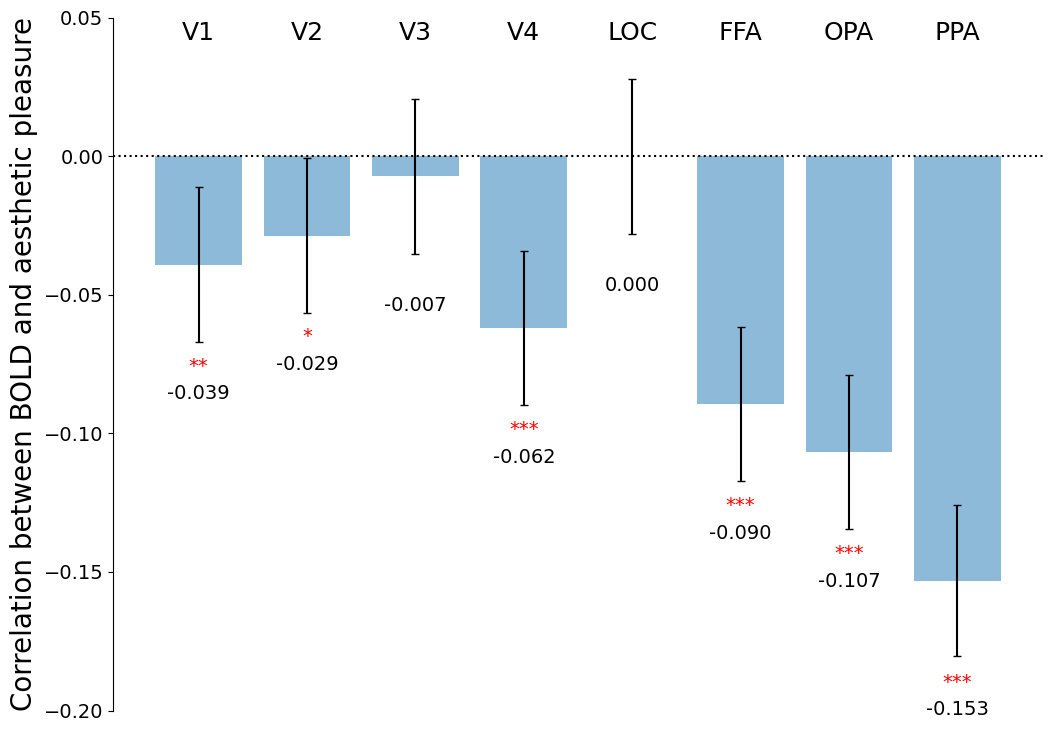

In [5]:
#@title Figure 3A
plt.figure(figsize=(12, 9))
height = 0.03
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
x = np.arange(len(rois))
width = 0.2
br1 = [i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
axis_label_size = 20

# add whole correlation as dashed lines
df = pd.read_csv(final_data_path+'roi_individual_correlations_by_metric_item_level_avg.csv')
df_pval = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_metric_item_level_avg.csv')
markers_l = []
for count, metric in enumerate(metric_types):
  data_to_plot = []
  pvals = []
  for roi in rois:
    r = df[df.metric==metric][roi].iloc[0]
    p = df_pval[df_pval.metric==metric][roi].iloc[0]
    data_to_plot.append(r)
    pvals.append(p)
  markers = significance_markers(pvals)
  markers_l.extend(markers)
  print('pvals:', pvals)
  print('corrs:', data_to_plot)
# print(data_to_plot)
line_x_start = x - width/2
line_x_end = line_x_start + width
# plt.hlines(data_to_plot, line_x_start, line_x_end, linestyle='dashed', color='red', linewidth=2, label='all images')
plt.bar(line_x_start, data_to_plot, color='tab:blue', alpha=0.5)

yerr_lower = pd.read_csv(final_data_path+'roi_individual_correlation_lower_bound_by_metric_item_level_avg.csv')
yerr_upper = pd.read_csv(final_data_path+'roi_individual_correlation_higher_bound_by_metric_item_level_avg.csv')
yerr_lower = yerr_lower.iloc[0, :].values[1:]
yerr_upper = yerr_upper.iloc[0, :].values[1:]
print(yerr_upper-yerr_lower)
plt.errorbar(line_x_start, data_to_plot, yerr=[data_to_plot-yerr_lower, yerr_upper-data_to_plot],
             color='black', ecolor='black', capsize=3, fmt='none')


for n, marker in enumerate(markers):
  # add asterisks
  plt.text(
      line_x_start[n],
      data_to_plot[n]-0.04,
      markers[n],
      ha='center',
      va='bottom',
      color='red',
      fontsize=14
      )
  # add roi labels
  plt.text(
      line_x_start[n],
      0.04,
      rois[n],
      ha='center',
      va='bottom',
      color='black',
      fontsize=18
      )
  # add corr vals
  plt.text(
      line_x_start[n],
      data_to_plot[n]-0.05,
      "{:.3f}".format(round(data_to_plot[n],3)),
      ha='center',
      va='bottom',
      color='black',
      fontsize=14
      )

# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
bottom_spine = plt.gca().spines['bottom']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)
bottom_spine.set_visible(False)

plt.ylabel('Correlation between BOLD and aesthetic pleasure', fontsize=axis_label_size)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks([])
plt.ylim(-0.20, 0.05)
plt.axhline(0, color='black', linestyle='dotted')
plt.savefig('group_avg_roi_correlations_all.png')
plt.show();


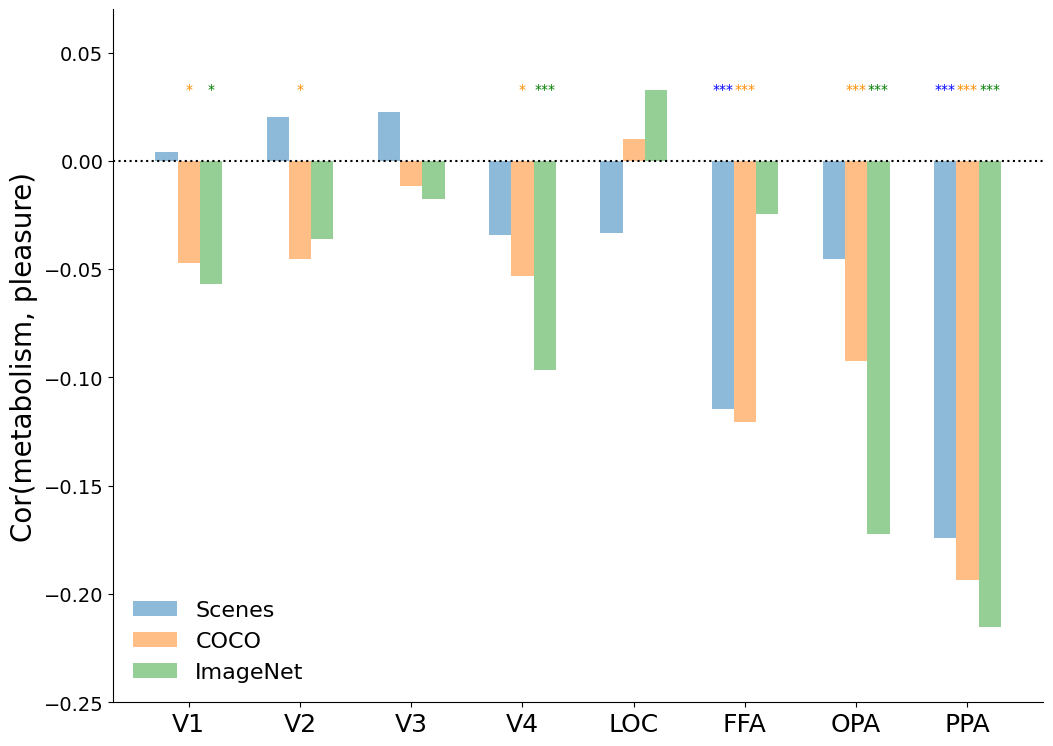

In [ ]:
#@title Figure S2
plt.figure(figsize=(12, 9))
height = 0.03
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
axis_label_size = 20

# by dataset
metric = ['sum_all'][0]
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [4*i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
datasets = ['Scenes', 'COCO', 'ImageNet']

df = pd.read_csv(final_data_path+'roi_individual_correlations_by_dataset_item_level_avg.csv')
df_pval = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_dataset_item_level_avg.csv')

x = np.arange(len(rois))
width = 0.2
for count, dataset in enumerate(datasets):
  data_to_plot = []
  for roi in rois:
    r = df[(df.metric==metric)&(df.dataset==dataset)][roi].iloc[0]
    data_to_plot.append(r)

  bars = plt.bar(x + count*width, data_to_plot, width, label=dataset, alpha=0.5)

  pvals = list(df_pval[(df_pval.metric==metric)&(df_pval.dataset==dataset)].iloc[0])[2:]

  markers = significance_markers(pvals)

  for count1, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, height, markers[count1], ha='center', va='bottom', color=marker_col[count], fontsize=10)

# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)

# plt.ylabel('Correlation between metabolic expenditure and pleasure', fontsize=axis_label_size)
plt.ylabel('Cor(metabolism, pleasure)', fontsize=axis_label_size)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(x + width * (len(datasets) - 1) / 2, rois, fontsize=18)
# plt.xticklabels(rois, fontsize=18)
plt.legend(fontsize=16, loc='lower left', frameon=False)
plt.ylim(-0.25, 0.07)
plt.axhline(0, color='black', linestyle='dotted')
plt.savefig('group_avg_roi_correlations_subset.png')


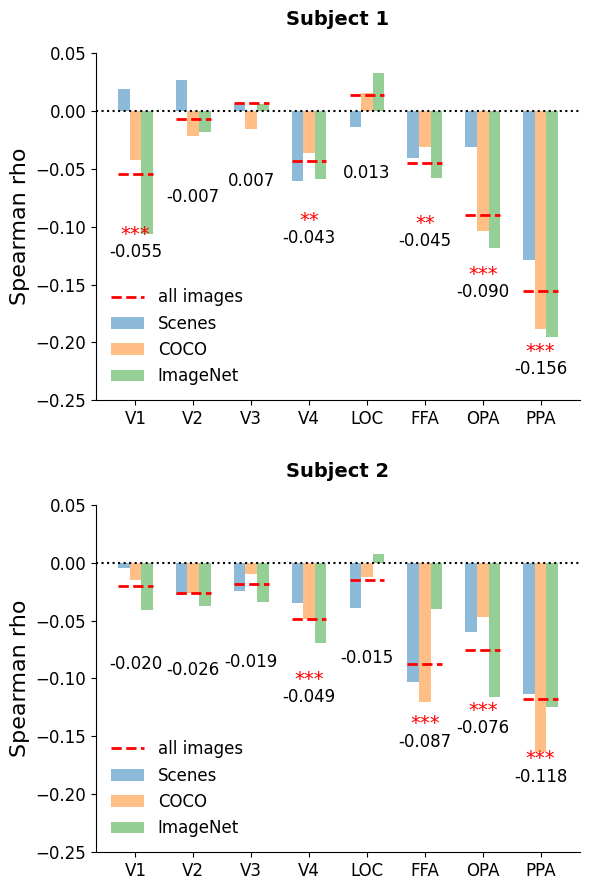

In [32]:
#@title Figure S3
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 9))

n_subjects = 4
height = 0.03
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
axis_label_size = 16

metric = ['sum_all'][0]
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [4*i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
datasets = ['Scenes', 'COCO', 'ImageNet']

df_dataset = pd.read_csv(final_data_path+'roi_individual_correlations_by_dataset_subjectwise.csv')
df_pval_dataset = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_dataset_subjectwise.csv')

df_metric = pd.read_csv(final_data_path+'roi_individual_correlations_by_metric_subjectwise.csv')
df_pval_metric = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_metric_subjectwise.csv')

for subject in range(2):

  # by dataset

  df = df_dataset[df_dataset.subject==subject+1]
  df_pval = df_pval_dataset[df_pval_dataset.subject==subject+1]

  x = np.arange(len(rois))
  width = 0.2
  for count, dataset in enumerate(datasets):
    data_to_plot = []
    for roi in rois:
      r = df[(df.metric==metric)&(df.dataset==dataset)][roi].iloc[0]
      data_to_plot.append(r)
    bars = ax[subject%2].bar(x + count*width, data_to_plot, width, label=dataset, alpha=0.5)

  # add whole correlation as dashed lines
  df = df_metric[df_metric.subject==subject]
  df_pval = df_pval_metric[df_pval_metric.subject==subject]
  markers_l = []
  for count, metric in enumerate(metric_types):
    data_to_plot = []
    pvals = []
    for roi in rois:
      r = df[df.metric==metric][roi].iloc[0]
      p_ = df_pval[df_pval.metric==metric][roi].iloc[0]
      data_to_plot.append(r)
      pvals.append(p_)
    markers = significance_markers(pvals)
    markers_l.extend(markers)
  for n, marker in enumerate(markers):
    # add corr vals
    ax[subject%2].text(
        line_x_start[n] + width*3/2,
        data_to_plot[n]-0.075,
        # 0.025,
        "{:.3f}".format(round(data_to_plot[n],3)),
        ha='center',
        va='bottom',
        color='black',
        fontsize=12
        )

  line_x_start = x - width/2
  line_x_end = line_x_start + width*3
  ax[subject%2].hlines(data_to_plot, line_x_start, line_x_end, linestyle='dashed', color='red', linewidth=2, label='all images')
  for n, marker in enumerate(markers):
    ax[subject%2].text(
        line_x_start[n] + width*3/2,
        data_to_plot[n]-0.06,
        markers[n],
        ha='center',
        va='bottom',
        color='red',
        fontsize=14
        )

  ax[subject%2].spines['top'].set_visible(False)
  ax[subject%2].spines['right'].set_visible(False)
  ax[subject%2].spines['bottom'].set_visible(True)
  ax[subject%2].spines['left'].set_visible(True)

  ax[subject%2].axhline(0, color='black', linestyle='dotted')
  ax[subject%2].set_ylabel('Spearman rho', fontsize=axis_label_size)


  ax[subject%2].set_xticks(x + width * (len(datasets) - 1) / 2, rois, fontsize=axis_label_size)
  # plt.xticklabels(rois, fontsize=18)
  # plt.legend(fontsize=10, loc='upper right', frameon=False)
  ax[subject%2].set_ylim(-0.25, 0.05)
  ax[subject%2].tick_params(axis='both', which='major', labelsize=12)
  ax[subject%2].set_title(f'Subject {subject+1}', pad=20, fontsize=14, weight='bold')
  ax[subject%2].legend(fontsize=12, loc='lower left', frameon=False)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('Figure_S3_sub1to2.png')

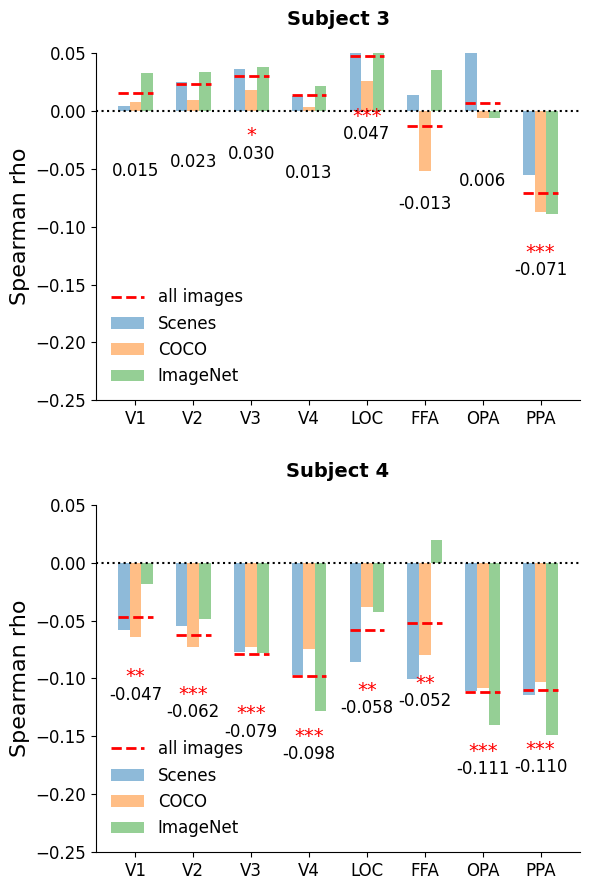

In [34]:
#@title Figure S4
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 9))

n_subjects = 4
height = 0.03
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
axis_label_size = 16

metric = ['sum_all'][0]
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [4*i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
datasets = ['Scenes', 'COCO', 'ImageNet']

df_dataset = pd.read_csv(final_data_path+'roi_individual_correlations_by_dataset_subjectwise.csv')
df_pval_dataset = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_dataset_subjectwise.csv')

df_metric = pd.read_csv(final_data_path+'roi_individual_correlations_by_metric_subjectwise.csv')
df_pval_metric = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_metric_subjectwise.csv')

for subject in range(2,4):

  # by dataset

  df = df_dataset[df_dataset.subject==subject+1]
  df_pval = df_pval_dataset[df_pval_dataset.subject==subject+1]

  x = np.arange(len(rois))
  width = 0.2
  for count, dataset in enumerate(datasets):
    data_to_plot = []
    for roi in rois:
      r = df[(df.metric==metric)&(df.dataset==dataset)][roi].iloc[0]
      data_to_plot.append(r)
    bars = ax[subject%2].bar(x + count*width, data_to_plot, width, label=dataset, alpha=0.5)

  # add whole correlation as dashed lines
  df = df_metric[df_metric.subject==subject]
  df_pval = df_pval_metric[df_pval_metric.subject==subject]
  markers_l = []
  for count, metric in enumerate(metric_types):
    data_to_plot = []
    pvals = []
    for roi in rois:
      r = df[df.metric==metric][roi].iloc[0]
      p_ = df_pval[df_pval.metric==metric][roi].iloc[0]
      data_to_plot.append(r)
      pvals.append(p_)
    markers = significance_markers(pvals)
    markers_l.extend(markers)
  for n, marker in enumerate(markers):
    # add corr vals
    ax[subject%2].text(
        line_x_start[n] + width*3/2,
        data_to_plot[n]-0.075,
        # 0.025,
        "{:.3f}".format(round(data_to_plot[n],3)),
        ha='center',
        va='bottom',
        color='black',
        fontsize=12
        )

  line_x_start = x - width/2
  line_x_end = line_x_start + width*3
  ax[subject%2].hlines(data_to_plot, line_x_start, line_x_end, linestyle='dashed', color='red', linewidth=2, label='all images')
  for n, marker in enumerate(markers):
    ax[subject%2].text(
        line_x_start[n] + width*3/2,
        data_to_plot[n]-0.06,
        markers[n],
        ha='center',
        va='bottom',
        color='red',
        fontsize=14
        )

  ax[subject%2].spines['top'].set_visible(False)
  ax[subject%2].spines['right'].set_visible(False)
  ax[subject%2].spines['bottom'].set_visible(True)
  ax[subject%2].spines['left'].set_visible(True)

  ax[subject%2].axhline(0, color='black', linestyle='dotted')
  ax[subject%2].set_ylabel('Spearman rho', fontsize=axis_label_size)


  ax[subject%2].set_xticks(x + width * (len(datasets) - 1) / 2, rois, fontsize=axis_label_size)
  # plt.xticklabels(rois, fontsize=18)
  # plt.legend(fontsize=10, loc='upper right', frameon=False)
  ax[subject%2].set_ylim(-0.25, 0.05)
  ax[subject%2].tick_params(axis='both', which='major', labelsize=12)
  ax[subject%2].set_title(f'Subject {subject+1}', pad=20, fontsize=14, weight='bold')
  ax[subject%2].legend(fontsize=12, loc='lower left', frameon=False)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('Figure_S4_sub3to4.png')

In [ ]:
#@title Figure S3+S4
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

n_subjects = 4
height = 0.03
metric_types = ['sum_all']
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
axis_label_size = 16

metric = ['sum_all'][0]
rois = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'OPA', 'PPA']
br1 = [4*i for i in range(len(rois))]
marker_col = ['blue', 'darkorange', 'green']
datasets = ['Scenes', 'COCO', 'ImageNet']

df_dataset = pd.read_csv(final_data_path+'roi_individual_correlations_by_dataset_subjectwise.csv')
df_pval_dataset = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_dataset_subjectwise.csv')

df_metric = pd.read_csv(final_data_path+'roi_individual_correlations_by_metric_subjectwise.csv')
df_pval_metric = pd.read_csv(final_data_path+'roi_individual_correlation_p_val_by_metric_subjectwise.csv')

for subject in range(4):

  # by dataset

  df = df_dataset[df_dataset.subject==subject+1]
  df_pval = df_pval_dataset[df_pval_dataset.subject==subject+1]

  x = np.arange(len(rois))
  width = 0.2
  for count, dataset in enumerate(datasets):
    data_to_plot = []
    for roi in rois:
      r = df[(df.metric==metric)&(df.dataset==dataset)][roi].iloc[0]
      data_to_plot.append(r)
    bars = ax[subject//2, subject%2].bar(x + count*width, data_to_plot, width, label=dataset, alpha=0.5)

  # add whole correlation as dashed lines
  df = df_metric[df_metric.subject==subject]
  df_pval = df_pval_metric[df_pval_metric.subject==subject]
  markers_l = []
  for count, metric in enumerate(metric_types):
    data_to_plot = []
    pvals = []
    for roi in rois:
      r = df[df.metric==metric][roi].iloc[0]
      p_ = df_pval[df_pval.metric==metric][roi].iloc[0]
      data_to_plot.append(r)
      pvals.append(p_)
    markers = significance_markers(pvals)
    markers_l.extend(markers)
  for n, marker in enumerate(markers):
    # add corr vals
    ax[subject//2, subject%2].text(
        line_x_start[n] + width*3/2,
        data_to_plot[n]-0.075,
        # 0.025,
        "{:.3f}".format(round(data_to_plot[n],3)),
        ha='center',
        va='bottom',
        color='black',
        fontsize=12
        )

  line_x_start = x - width/2
  line_x_end = line_x_start + width*3
  ax[subject//2, subject%2].hlines(data_to_plot, line_x_start, line_x_end, linestyle='dashed', color='red', linewidth=2, label='all images')
  for n, marker in enumerate(markers):
    ax[subject//2, subject%2].text(
        line_x_start[n] + width*3/2,
        data_to_plot[n]-0.06,
        markers[n],
        ha='center',
        va='bottom',
        color='red',
        fontsize=14
        )

  ax[subject//2, subject%2].spines['top'].set_visible(False)
  ax[subject//2, subject%2].spines['right'].set_visible(False)
  ax[subject//2, subject%2].spines['bottom'].set_visible(True)
  ax[subject//2, subject%2].spines['left'].set_visible(True)

  ax[subject//2, subject%2].axhline(0, color='black', linestyle='dotted')
  ax[subject//2, subject%2].set_ylabel('Spearman rho', fontsize=axis_label_size)


  ax[subject//2, subject%2].set_xticks(x + width * (len(datasets) - 1) / 2, rois, fontsize=axis_label_size)
  # plt.xticklabels(rois, fontsize=18)
  # plt.legend(fontsize=10, loc='upper right', frameon=False)
  ax[subject//2, subject%2].set_ylim(-0.25, 0.05)
  ax[subject//2, subject%2].tick_params(axis='both', which='major', labelsize=12)
  ax[subject//2, subject%2].set_title(f'Subject {subject+1}', pad=20, fontsize=14, weight='bold')
  ax[subject//2, subject%2].legend(fontsize=12, loc='lower left', frameon=False)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('Figure_S3+S4.png')